# Inference using TFLite

In [1]:
!pip install tflite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 9.4 MB/s eta 0:00:00


In [37]:
import numpy as np

def xywh2xyxy(x):
	# Convert bounding box (x, y, w, h) to bounding box (x1, y1, x2, y2)
	y = np.copy(x)
	y[..., 0] = x[..., 0] - x[..., 2] / 2 # top left x
	y[..., 1] = x[..., 1] - x[..., 3] / 2 # top left y
	y[..., 2] = x[..., 0] + x[..., 2] / 2 # bottom right x
	y[..., 3] = x[..., 1] + x[..., 3] / 2 # bottom right y
	return y

# NON MAXIMUM SUPPRESSION
def non_max_suppression(boxes, iou_threshold=0.5):
	if len(boxes) == 0:
		print("boxes are empty :o")
		return []

	# Sort the boxes by their detection probability in descending order
	sorted_indices = np.argsort(-boxes[:, 4])

	picked_indices = []
	while len(sorted_indices) > 0:
	  # Pick the box with the highest probability
		current_index = sorted_indices[0]
		picked_indices.append(current_index)

		# Calculate the IoU of the current box with the remaining boxes
		iou = calculate_iou(boxes[current_index], boxes[sorted_indices[1:]])

		# Identify the boxes with IoU greater than the threshold
		overlapping_indices = sorted_indices[1:][iou > iou_threshold]

		# Remove the overlapping indices from the list
		sorted_indices = np.setdiff1d(sorted_indices, np.concatenate(([current_index], overlapping_indices)), True)
	return np.array(picked_indices)

def calculate_iou(box, boxes):
    # Calculate the intersection coordinates
    x1 = np.maximum(box[0], boxes[:, 0])
    y1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[2], boxes[:, 2])
    y2 = np.minimum(box[3], boxes[:, 3])

    # Calculate the intersection area
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)

    # Calculate the union area
    box_area = (box[2] - box[0]) * (box[3] - box[1]) # (x2 - x1) * (y2 - y1)
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union = box_area + boxes_area - intersection

    # Calculate the IoU
    iou = intersection / union

    return iou

In [3]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

Shape boxes: (1, 116, 1344)
Shape masks: (1, 64, 64, 32)
bounding box for object with class index 22:


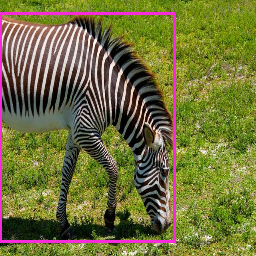

mask for object with class index 22:


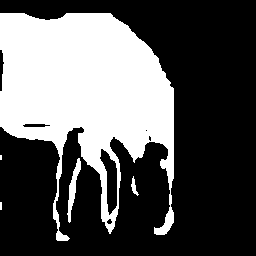

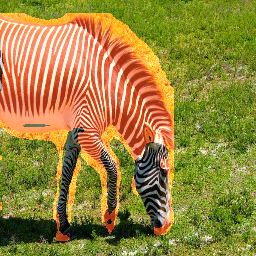

In [40]:
from IPython.utils.path import ensure_dir_exists
import sys
import numpy as np
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
import torch.nn.functional as F

np.set_printoptions(threshold=sys.maxsize)

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/yolov8s-seg_float16.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']

input_img_width = input_shape[1]
input_img_height = input_shape[2]

original_img = cv2.imread("/content/000000000034.jpg")

original_img_width = original_img.shape[1]
original_img_height = original_img.shape[0]

# Resize image to model's input size
resized_img = cv2.resize(original_img, (input_img_width, input_img_height))

input_data = np.array(resized_img, dtype=np.float32)
input_data /= 255.0 # normalize
input_data = np.expand_dims(input_data, axis=0) # (1,256,256,3)

# Load image as input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Perform inference
interpreter.invoke()

# Get output tensors
output_data_boxes = interpreter.get_tensor(output_details[0]['index'])
output_data_masks = interpreter.get_tensor(output_details[1]['index'])

print("Shape boxes: {}".format(output_data_boxes.shape))
print("Shape masks: {}".format(output_data_masks.shape))

# Process output data

# 37: the first 5 values "center x, center y, width, height and probability" of
#     the detected object, next 32 values are the propability for the mask
# 1344: the number of possible detected objects
boxesOutput = output_data_boxes[0].transpose() # (1344, 37)

conf_threshold = 0.4
iou_threshold = 0.6

number_of_segmentation_masks = 32
num_classes = boxesOutput.shape[1] - 4 - number_of_segmentation_masks

scores = np.max(boxesOutput[:, 4:4+num_classes], axis=1)

# copy only predictions with score bigger than threshold
box_predictions = boxesOutput[scores > conf_threshold, :]

box_predictions = box_predictions[..., :4+num_classes+number_of_segmentation_masks]

# TODO: Support for multi classes

# Perform nms on box predictions
box_predictions = xywh2xyxy(box_predictions)
indices = non_max_suppression(box_predictions, iou_threshold=iou_threshold)
nmsBoxes = box_predictions[indices]

if nmsBoxes.size == 0:
  print("no boxes after nms")
  sys.exit()

masks = output_data_masks[0].transpose(2, 0, 1) # (32,64,64)

# Add padding to all masks
inference_shape = tuple(masks.shape[1:])
gain = min(
    inference_shape[0] / input_img_width,
    inference_shape[1] / input_img_height
)
pad = (
    (inference_shape[0] - input_img_width * gain) / 2,
    (inference_shape[1] - input_img_height * gain) / 2
)
top, left = int(pad[1]), int(pad[0])
bottom, right = int(inference_shape[1] - pad[1]), int(inference_shape[0] - pad[0])

# Apply padding
mask_protos = []
for i in range(masks.shape[0]):
  mask_proto = masks[i]
  mask_proto = mask_proto[top:bottom, left:right]
  mask_proto = cv2.resize(mask_proto, (input_img_width, input_img_height))
  mask_protos.append(mask_proto)

rng = np.random.default_rng(3)
colors = rng.uniform(0, 255, size=(num_classes, 3))

# Create masks
final_masks = [];
classes = [];
for index, box in enumerate(nmsBoxes):
  index_of_object_with_heighest_probability = np.argmax(nmsBoxes[index, 4:4 + num_classes])
  classes.append(index_of_object_with_heighest_probability)

  mask_proto_scores = box[4:num_classes:]

  # Create final mask from mask protos (yolact)
  final_mask = np.zeros([input_img_width, input_img_height], dtype=np.float32)
  for j, mask_proto in enumerate(mask_protos):
    mask_proto *= mask_proto_scores[j]
    final_mask = final_mask + mask_proto

  final_mask = sigmoid(final_mask)

  final_mask[final_mask < 0.5] = 0
  final_mask[final_mask > 0.5] = 1

  mask_in_input_size = np.asarray(final_mask, dtype=np.uint8)
  mask_in_input_size *= 255

  mask_in_input_size = cv2.bitwise_not(mask_in_input_size)

  print("bounding box for object with class index {}:".format(index_of_object_with_heighest_probability))

  x1, y1, x2, y2 = box[:4]

  startX = int(x1)
  startY = int(y1)
  endX   = int(x2)
  endY   = int(y2)

  img_with_rect_in_input_size = np.zeros([input_img_width, input_img_height, 3], dtype=np.uint8)
  img_with_rect_in_input_size = cv2.rectangle(
    resized_img.copy(),
    (startX, startY),
    (endX, endY),
    colors[index_of_object_with_heighest_probability],
    2)

  cv2_imshow(img_with_rect_in_input_size)

  # crop mask to bounding box
  cropped_mask = np.zeros([input_img_width, input_img_height], dtype=np.uint8)
  cropped_mask[startY:endY, startX:endX] = mask_in_input_size[startY:endY, startX:endX]

  print("mask for object with class index {}:".format(index_of_object_with_heighest_probability))
  cv2_imshow(cropped_mask)

  final_masks.append(cropped_mask)

mask_overlay = np.zeros([input_img_width, input_img_height, 3], dtype=np.uint8)
for index, mask in enumerate(final_masks):
  three_channel_mask = cv2.merge((mask, mask, mask))
  three_channel_mask[np.where((three_channel_mask==[255, 255, 255]).all(axis=2))] = colors[index]
  mask_overlay = mask_overlay + three_channel_mask

resized_img_with_weighted_mask_img = cv2.addWeighted(resized_img, 1, mask_overlay, 0.8, 0)
cv2_imshow(resized_img_with_weighted_mask_img)

# Inference using YOLOv8 via PyTorch

In [ ]:
!git clone https://github.com/ultralytics/ultralytics.git

Cloning into 'ultralytics'...
remote: Enumerating objects: 10808, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 10808 (delta 18), reused 30 (delta 13), pack-reused 10764
Receiving objects: 100% (10808/10808), 7.04 MiB | 23.32 MiB/s, done.
Resolving deltas: 100% (7200/7200), done.


In [ ]:
cd /content/ultralytics

/content/ultralytics


In [ ]:
!pip install -r requirements.txt

Note: switching to '064d48e'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 064d48e `ultralytics 8.0.119` RTDETR Trainer and ViT Docs (#3236)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


100%|██████████| 52.4M/52.4M [00:00<00:00, 59.1MB/s]

image 1/1 /content/6WZZRS45TSXGJYPONYE6KL5A6M.jpg: 640x640 10 cars, 1 bus, 3249.8ms
Speed: 18.6ms preprocess, 3249.8ms inference, 76.5ms postprocess per image at shape (1, 3, 640, 640)


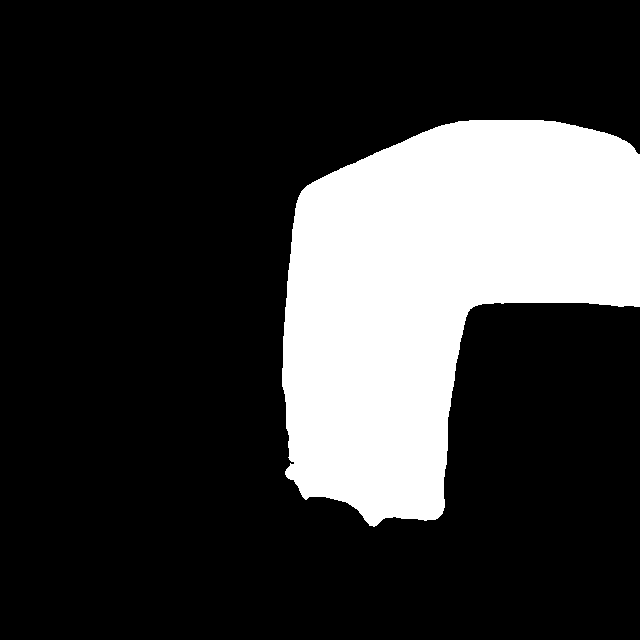

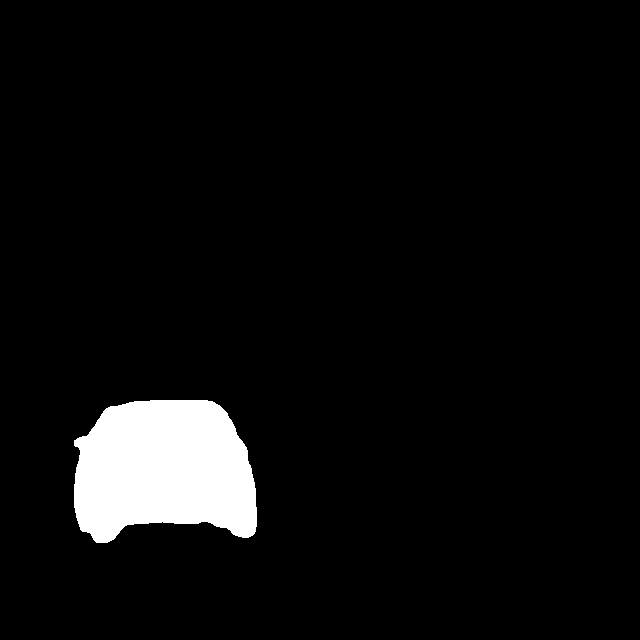

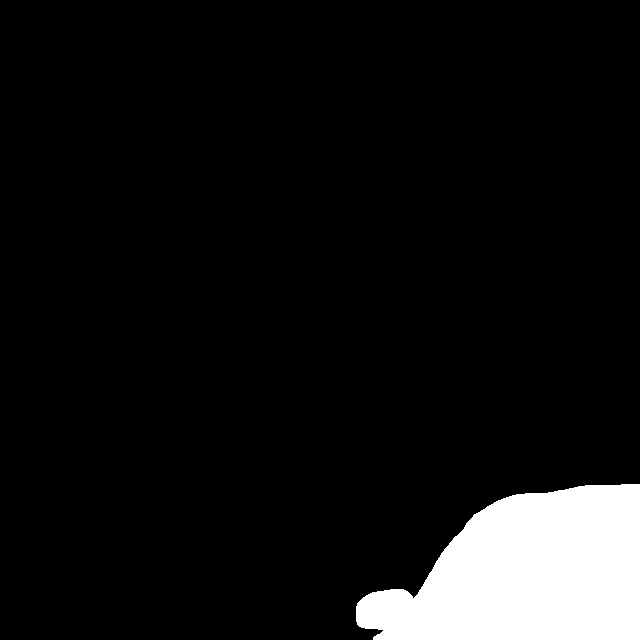

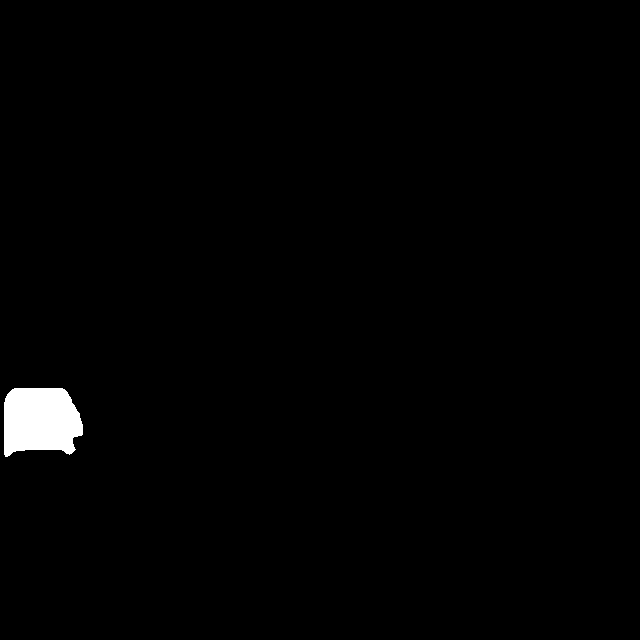

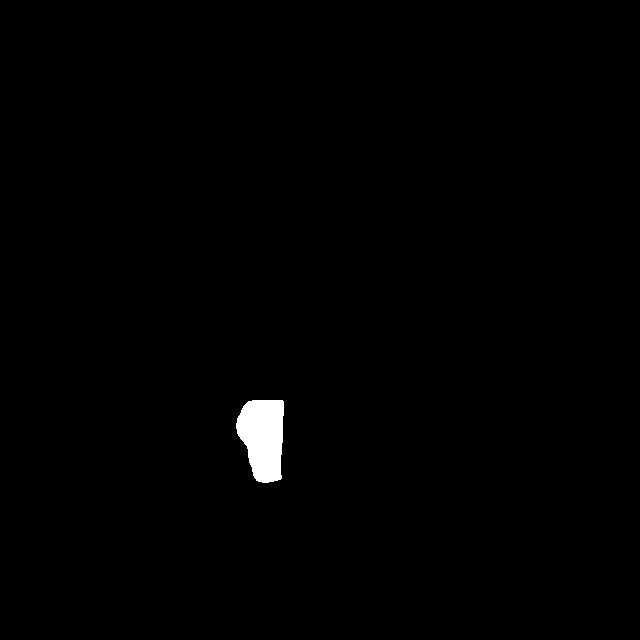

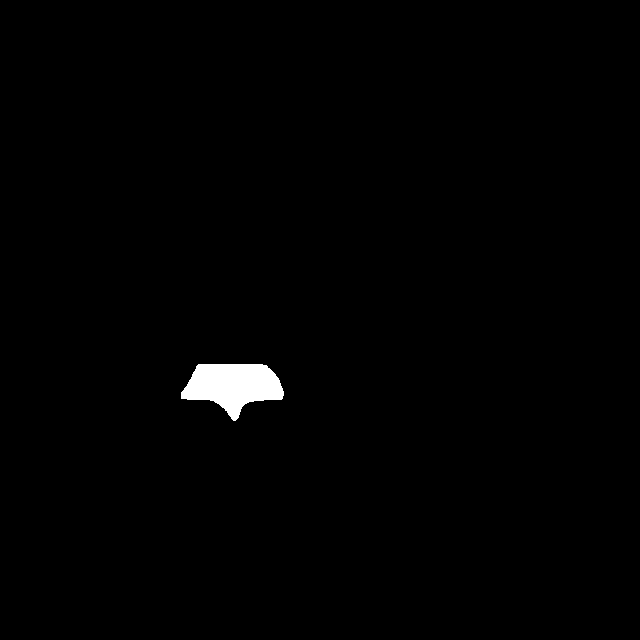

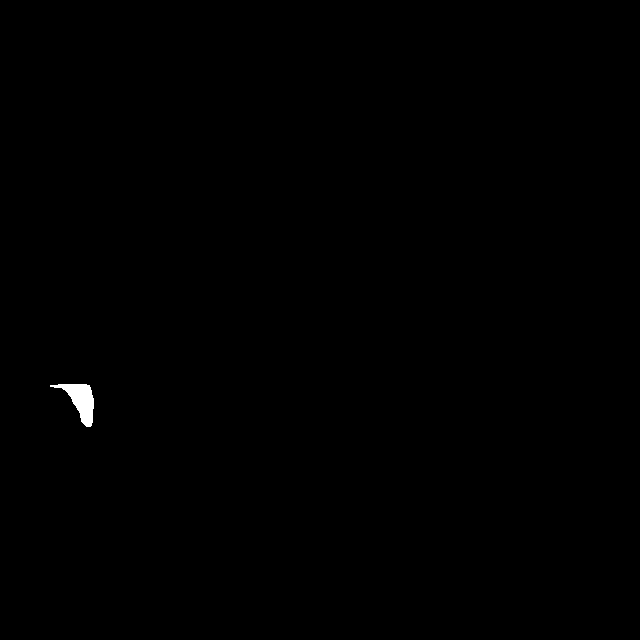

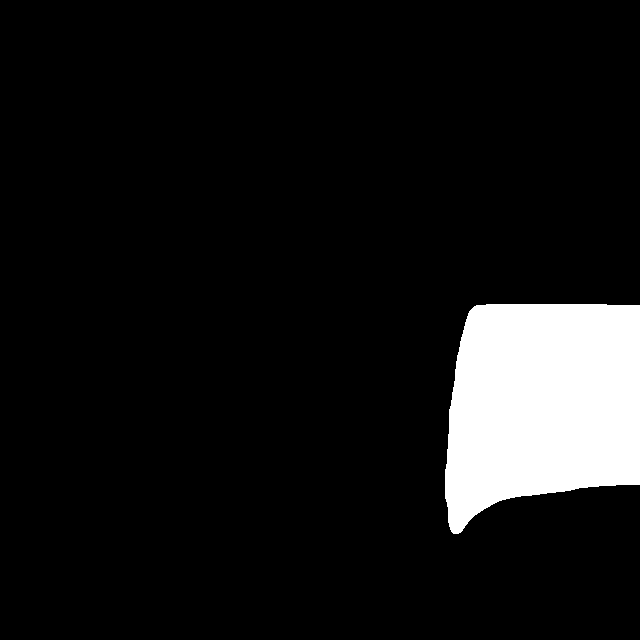

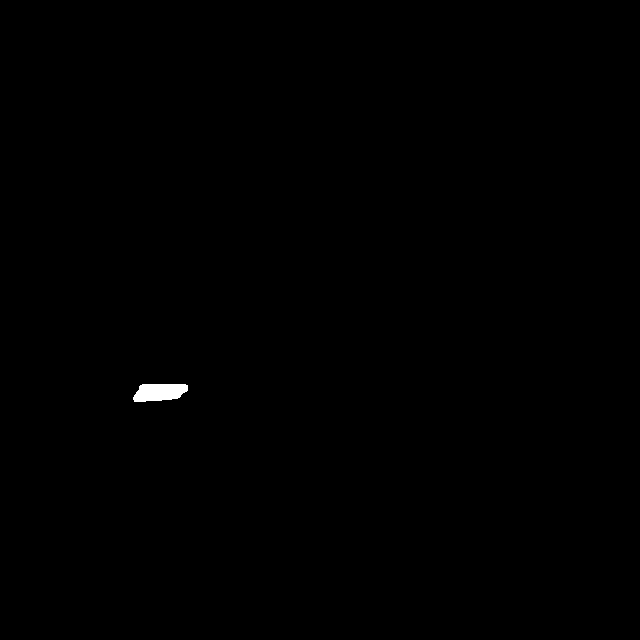

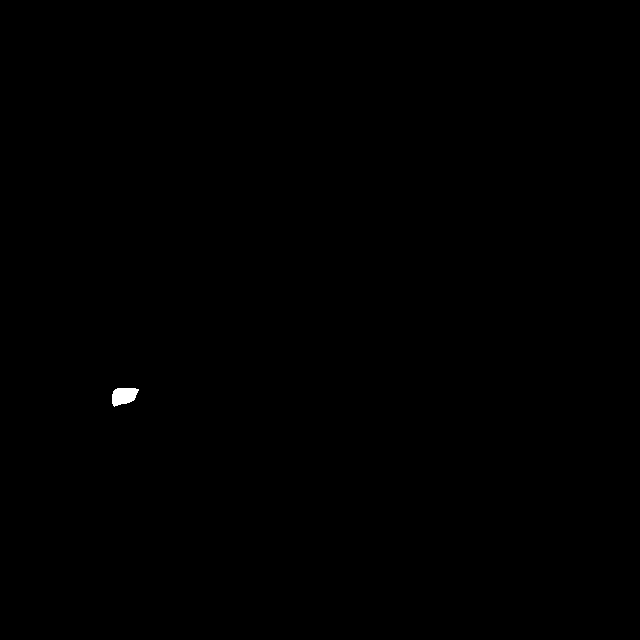

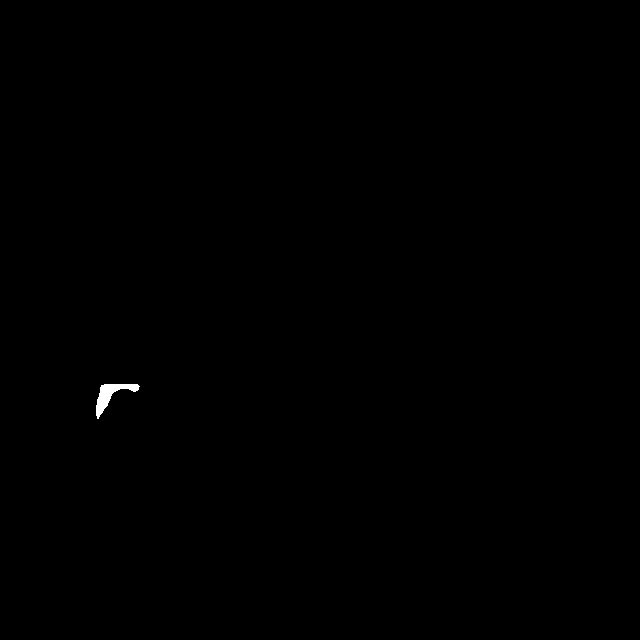

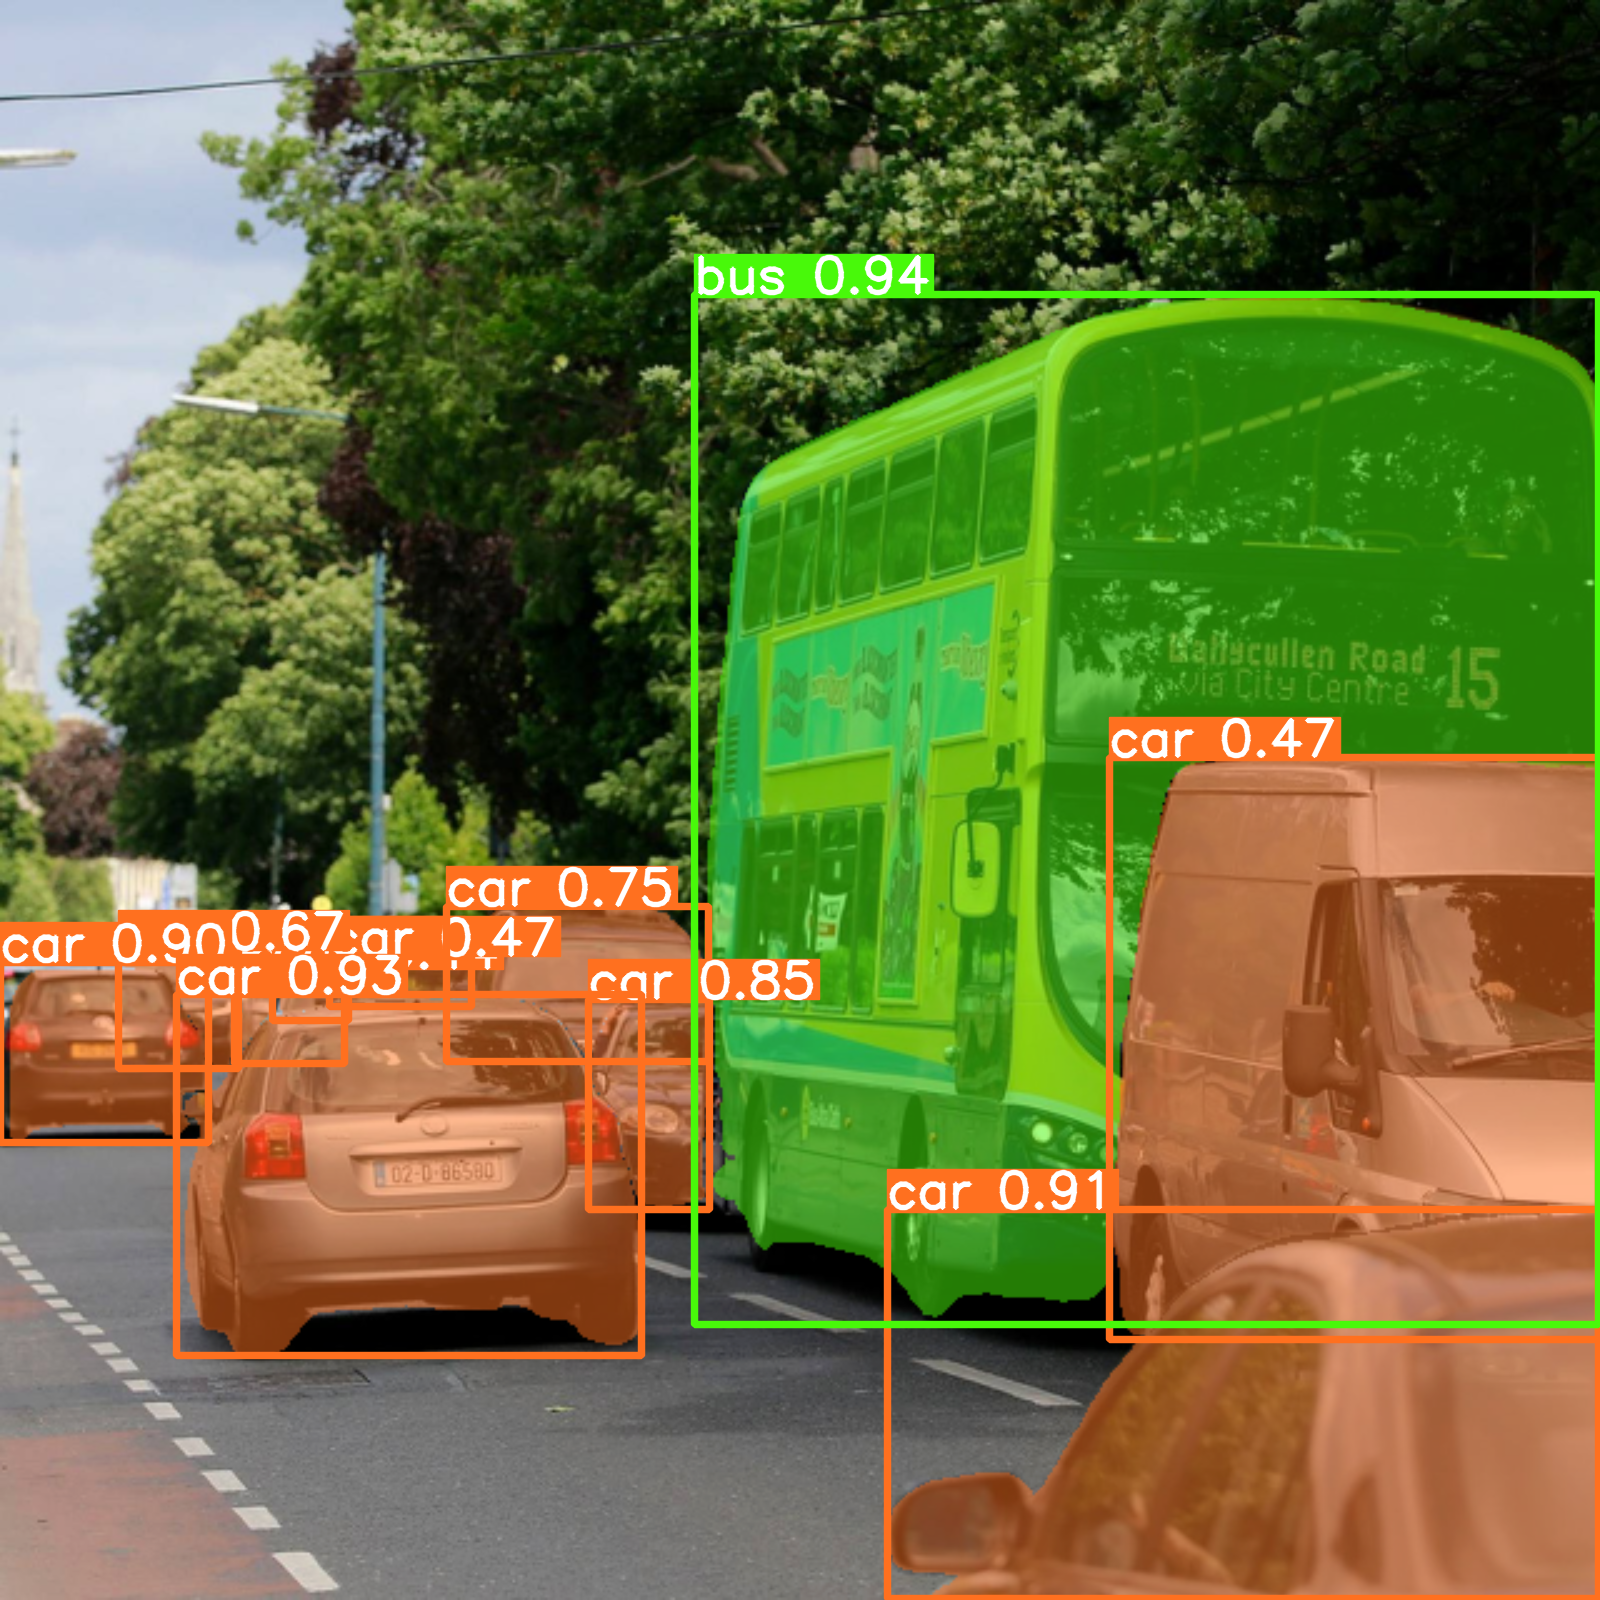

In [ ]:
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow

model = YOLO('yolov8m-seg.pt')  # load a pretrained model (recommended for training)
# model = YOLO('/content/best.pt')

results = model("/content/6WZZRS45TSXGJYPONYE6KL5A6M.jpg")

res_plotted = results[0].plot()
cv2_imshow(res_plotted)